In [1]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Defining synthetic data
series = np.sin(0.1*np.arange(200)) + np.random.randn(200)*0.1

# L - 200

In [3]:
type(series)

numpy.ndarray

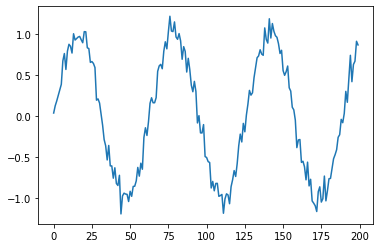

In [ ]:
# plot it
plt.plot(series)
plt.show()

In [ ]:
# Build the dataset
# We will use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]   # Values from 0 to 9 (10values)
  X.append(x)         # First observation
  y = series[t+T]     # 10th value
  Y.append(y)         # append first Y

X = np.array(X).reshape(-1, T)      # T columns must have
Y = np.array(Y)                     
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

# L=200
# T = 11 (10 values of X plus one value of Y)
# N = L-T+1=200-11+1=190 (Observations)

X.shape (190, 10) Y.shape (190,)


In [ ]:
#Build the autoregressive linear model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)

model.compile(
  loss='mse',
  optimizer=Adam(learning_rate=0.1),
)

For time series we don't randomly split train and test data randomly (previous scikit learn). It trains on first half and validates on second half

In [ ]:
# train the model
# 
r = model.fit(
  X[:N//2], Y[:N//2],     # First half for training
  epochs=80,
  validation_data=(X[N//2:], Y[N//2:]),  #Second half for valdiation
)

Epoch 1/80
3/3 [==============================] - 0s 71ms/step - loss: 0.7229 - val_loss: 0.4600
Epoch 2/80
3/3 [==============================] - 0s 17ms/step - loss: 0.6290 - val_loss: 0.2711
Epoch 3/80
3/3 [==============================] - 0s 16ms/step - loss: 0.1413 - val_loss: 0.1493
Epoch 4/80
3/3 [==============================] - 0s 16ms/step - loss: 0.2436 - val_loss: 0.1593
Epoch 5/80
3/3 [==============================] - 0s 26ms/step - loss: 0.1373 - val_loss: 0.0579
Epoch 6/80
3/3 [==============================] - 0s 23ms/step - loss: 0.0783 - val_loss: 0.1441
Epoch 7/80
3/3 [==============================] - 0s 16ms/step - loss: 0.1149 - val_loss: 0.0495
Epoch 8/80
3/3 [==============================] - 0s 17ms/step - loss: 0.0453 - val_loss: 0.0866
Epoch 9/80
3/3 [==============================] - 0s 19ms/step - loss: 0.0916 - val_loss: 0.0928
Epoch 10/80
3/3 [==============================] - 0s 24ms/step - loss: 0.0580 - val_loss: 0.0431
Epoch 11/80
3/3 [============

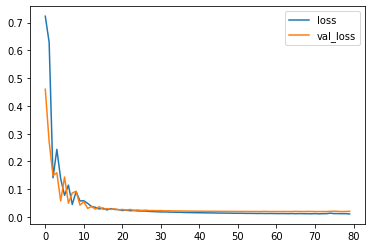

In [ ]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

Doing forecasting wrong way: Using future value in input X 

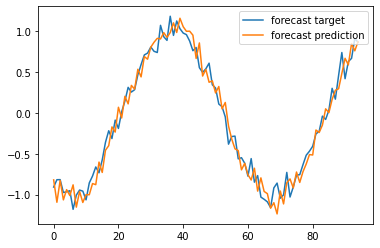

In [ ]:
# "Wrong" forecast using true targets

validation_target = Y[N//2:]    #Assign the validation target#
validation_predictions = []     #Empty list for predicted values

# index of first validation input
i = N//2                        # Set the first index for validation start data point

while len(validation_predictions) < len(validation_target):    #continue till length of validations predictions < validation target
  p = model.predict(X[i].reshape(1, -1))[0,0] # 1x1 array -> scalar    # Call model.predict for predicting p using X[i] values Why reshaping???? -
                                                                       # 1. Input should be 2d array and X is a 2D array as of now, but if we index then we get 1d array of length T so we get (1,T)
                                                                       # 2. The output is not in the right shape (N*k) N - samples k-output nodes, 1 sample and 1 output node - returns 1*1 2d array (matrix with 1 row and 1 column)
                                                                       # so get the scalar value we do [0,0] that gets stroed in p
  i += 1                                                    
  
  # update the predictions list
  validation_predictions.append(p)                    

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()         # Both are well in sync that forecast target is not visible

# Overall problem is here that we are using original X inputs each time to predict values instead of including predicted value in the next iteration of prediction.

Forecasting it correct way

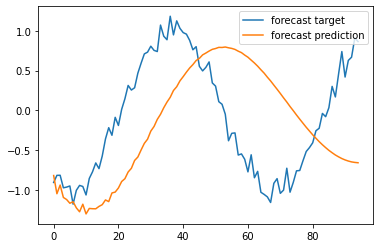

In [ ]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[N//2:]
validation_predictions = []

# first validation input
last_x = X[N//2] # 1-D array of length T  # Set the variable to be the first input vector because we need to take predicted values in consideration for prediction

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)      #Make the next new input with new predicted value append (shifting current X set to left and add current predicted value at end)
                                    #np.roll(x,-1) function shifts the values to left by 1 position and new value is appended at last index
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [ ]:
#Re run the notebook after adding noise
# So the forecasting is not correct but the structure of the sine function was detected correctly. Auto regressive model does struggle in forecasting.
# Hence, Recurrent neural network play a huge role in sequential data for forecasting.